# Population receptive field plotting functions - for the surface

A more specific overview of my custom methods for plotting infomation on the cortical surface

[1] Basic PRF plotting - time series; visual fields

[2] Very quick flat map plotting; can be done inside a jupyter notebook

[3] Plotly + dash based - for interative plotting


Requirements for running this:

* Freesurfer directory 
* Freesurfer subject ID
* vertex wise data to plot on the surface (i.e., an array of length n_vx) (ideally this can be the prfpy fitted parameters)

Optional - but useful for interative plotting

* surface time series
* prfpy parameter fits
* prfpy model (to generate predictions)


### To view a movie showing dag_prf_utils surface plotting click on 'mov.mp4' and download the file

<video controls>
    <source src="./mov.mp4" type="video/mp4">
    Your browser does not support the video tag.
</video>



In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
from dag_prf_utils.prfpy_ts_plotter import TSPlotter
try: # Support different prfpy versions
    from prfpy_csenf.model import Iso2DGaussianModel
    from prfpy_csenf.stimulus import PRFStimulus2D
except:
    from prfpy.model import Iso2DGaussianModel
    from prfpy.stimulus import PRFStimulus2D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Error importing pycortex... Not a problem unless you want to use pycortex stuff


### edit the following to load your own specific data

In [ ]:
# FOR MY OWN TESTING OF THIS EXAMPLE FOLDER
# -> Freesurfer directory
sub = 'sub-02'
fs_dir = '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer'

# -> load design matrix, time series and prfpy parameters from one of my projects
# 
from pfa_scripts.load_saved_info import *
prfpy_numpy_array = load_data_prf('sub-02', 'AS0', 'gauss')['AS0']['gauss']
time_series = load_data_tc(sub=sub, ses='ses-1', task_list='AS0', )['AS0']
design_matrix = get_design_matrix_npy(['AS0'])['AS0'][:,:,5:]         

# Create prfpy stimulus & model
assert design_matrix.shape[-1]==time_series.shape[-1]
prf_stim = PRFStimulus2D(
    screen_size_cm=39.3,                                    # height of the screen (i.e., the diameter of the stimulated region)    
    screen_distance_cm=196,                                 # Distance of screen to eye
    design_matrix=design_matrix,                            # dm (npix x npix x time_points)
    TR=1.5,                                                 # TR
    )   
prfpy_model = Iso2DGaussianModel(stimulus=prf_stim)

# Now make the "ts plotter": which will make plotting our prf information very easy
prfs  = TSPlotter(
    prf_params=prfpy_numpy_array,
    model='gauss',
    prfpy_model=prfpy_model,
    real_ts=time_series
)

# If you don't want to work with prfpy directly -> just load your own version for some of these
# ** Control visibility of data ** [using mask, or alpha, or both...] 
# If you don't want to show the values of every point (for example because it is outside the visual cortex). You may want to hide it. 
# If you are plotting PRFs, then you may want to hide the bad fits. So you can create a mask for where the rsq<threshold (e.g., 0.1)
# data_mask: what to show (TRUE), what to hide (FALSE)
# -> should boolean 1D np.ndarray, where the length = number of vertices in subject surface
# -> if unspecified, all surface functions assume TRUE for all voxels
# data_alpha: transparency (invisible = 0), (opaque = 1).
# Often you will do this based on the rsquared of your model

polar_angle_data = prfs.pd_params['pol'].to_numpy()
eccentricity_data = prfs.pd_params['ecc'].to_numpy()
data_mask = prfs.return_vx_mask(th={'min-rsq':.1, 'max-ecc':5})
data_rsq = prfs.pd_params['rsq'].to_numpy()
data_alpha = data_rsq.copy()


/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/prf_no_hrf/sub-02/ses-1/sub-02_model-gauss_roi-all_task-AS0-fits_stage-iter_constr-tc_desc-prf_params.pkl
prf_params.shape[-1]=8
include hrf = True
include rsq = True


# [1] Basic plotting

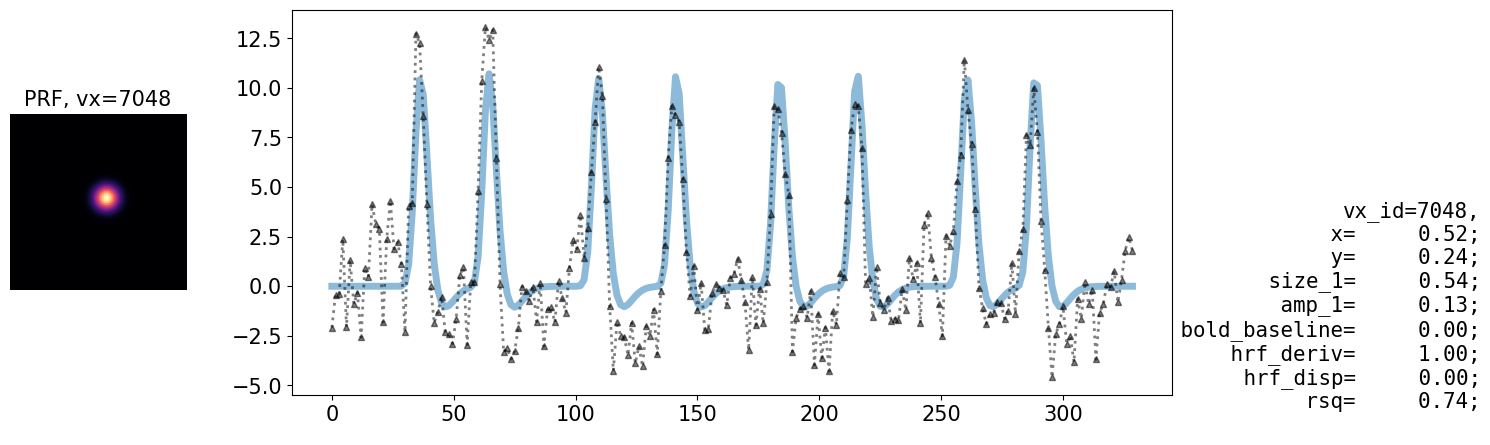

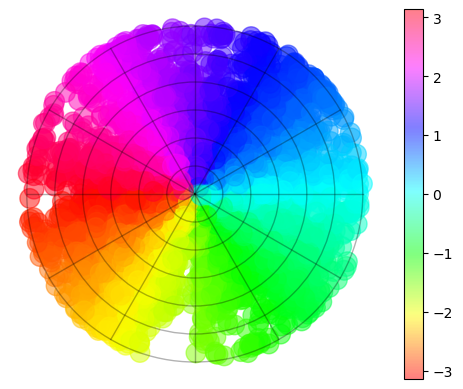

In [ ]:
# Plot the data, prediction, and PRF location & extent
_ = prfs.prf_ts_plot(idx=7048) # an example vertex with a very good fit
# Next plotting around the visual field
plt.figure()
prfs.visual_field(
    dot_col='pol', # Use polar angle
    th={'min-rsq': 0.1, 'max-ecc': 5}, # Only include fits with R2 greater than 0.1, and eccentricity inside the stimulated region
    dot_cmap='hsv', # Pick a nice colormap

)


# [2] Inline plotting -> fast flat maps

In [ ]:
from dag_prf_utils.mesh_maker import GenMeshMaker
gm = GenMeshMaker(
    sub = sub,          # Specify the subject 
    fs_dir = fs_dir,    # Specify the freesurfer directory
    )


Using fs dir = /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...


centering!
Faces with missing vx: 259260
Faces with long edges: 1155
0.08003151014498924
centering!
Faces with missing vx: 258892
Faces with long edges: 1127
0.08512908948272328


{'cmap': 'viridis', 'vmin': 0, 'vmax': 5}

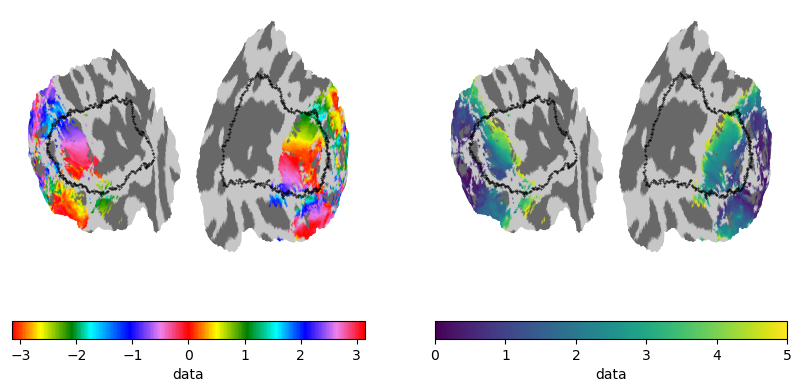

In [31]:
# Try to make a flat surface to plot here
# Let look at V1
from dag_prf_utils.fs_tools import dag_load_roi
v1_bool = dag_load_roi(sub, roi='V1_exvivo', fs_dir=gm.fs_dir) # Load the "V1_exvivo" which all freesurfer subjects will have
# Use this to make a flat map 
gm.make_flat_map(
    centre_bool=v1_bool,            # centre the surface here
    vx_to_include = v1_bool,        # cut out everything apart from v1
    morph = 20,                     # Add a little buffer around the edge of the ROI
    method='latlon',                # Use a primitive latitude and longitude metho...
)
# Now lets plot the polar angle and eccentricity data
fig, axs = plt.subplots(1,2, figsize=(10,5))
gm.flat_mpl(
    data=polar_angle_data,  # What to plot -> polar angle 
    data_mask=data_mask,    # Where to plot it (only include the good fits)
    cmap='marco_pol',       # What color map to use 
    vmin=-np.pi, vmax=np.pi,# Limits of data (polar angle in radians) 
    roi_list=['V1_exvivo'], # Lets also plot the outline of V1_exvivo       
    ax=axs[0], 
    )
# Same again but for eccentricity
gm.flat_mpl(
    data=eccentricity_data, # What to plot -> eccentricity 
    data_mask=data_mask,    # Where to plot it (only include the good fits)
    cmap='viridis',         # What color map to use 
    vmin=0, vmax=5,         # Limits of data (polar angle in radians) 
    roi_list=['V1_exvivo'], # Lets also plot the outline of V1_exvivo       
    ax=axs[1], 
    )

# [3] Interactive plotting

### Plotly plotting
* requires plotly library (conda install)
* Can put more than one in a single html (i.e., subfigures)
* Also an online interactive plotter!


In [32]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from dag_prf_utils.mesh_dash import dag_mesh_pickle, MeshDash

##### To make interactive dash in browser
You can toggle the:
* rsq threshold
* inflation (pial-inflated)
* colormaps (any possible matplolib); vmin, vmax
* show ROIs, or not... 

In [45]:

fs = MeshDash(
    sub, 
    fs_dir=fs_dir,
    output_dir='z_dash',
    )
fs.web_get_ready()
fs.web_add_vx_col(
    data=polar_angle_data,
    data4mask =data_rsq,
    vmin=-np.pi, vmax=np.pi, 
    cmap='marco_pol', 
    vx_col_name=f'pol'
)

fs.web_add_vx_col(
    data=eccentricity_data, 
    data4mask =data_rsq,
    cmap='ecc2', 
    vmin=0, vmax=5, 
    vx_col_name=f'ecc'
)

# Other cool things....
# you can add ROIs
fs.web_add_roi(roi_list='V1')

# You can also add conditional functions to do plotting. 
# For example if you have a function to plot the timeseries put that here 
# def my_plot_function(vertex_id):
#     fig = plt.figure()
#     # Do some plotting based on the vertex...
#     return fig

# We have already made one here -> 

fs.web_add_mpl_fig_maker(
    mpl_func=prfs.prf_ts_plot, # my_plot_function
    mpl_key='plot',
    mpl_kwargs={'return_fig':True},
) # you can add more than one...



Using fs dir = /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...


Just using undersurface file..
No vx to mask
No vx to mask
*** USING BASIC RSQ THRESHOLD ***
Make RGB time = 0.06017923355102539


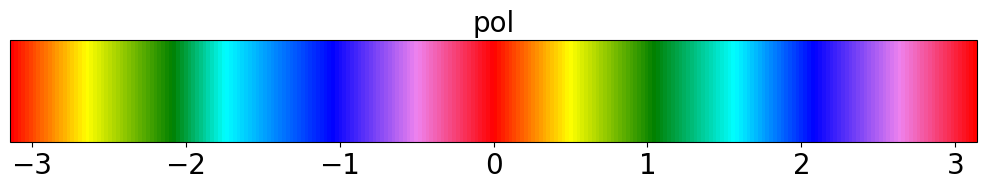

COL DROPDOWN CALLBACK
CLEAR LOWER CALLBACK
CLEAR UPPER CALLBACK
INFLATE CALLBACK
THRESH TEXT CALLBACK

0
ROI CALLBACK
Toggled OFF
Inflate time = 0.021485328674316406


In [46]:
# To launch app from here 
app = fs.web_launch_with_dash() # change to exciting to use silly fonts...
# Open the app in a browser (or in the notebook)
app.run_server(mode='external', host='127.0.0.1', port=8000, debug=False, use_reloader=False) 
# Go to localhost:8000 in your browser to see the app.

In [47]:
# To save it to a pickle 
dag_mesh_pickle(fs) # dumps it as a pickle file

# Use /bin/dag_open_dash_surf --pkl_path <pickle-file> to open and launch the file again
# If you get the error
# PicklingError: Can't pickle <class 'dag_prf_utils.mesh_dash.MeshDash'>: it's not the same object as dag_prf_utils.mesh_dash.MeshDash
# Try restarting your kernel and running again...

pickling mesh_dash object to : z_dash/mesh_dash.pkl


Also can do automatic loading of prf parameter files 

bin/dag_auto_dash_surf_from_file 

##### To export html files (don't bother with dash, less interactive)

In [35]:

gmm = MeshDash(
    sub=sub, 
    fs_dir=fs_dir,
    output_dir='z_gmm_plotly') # Make the 'generic mesh maker' instance
# Make 2 plots side by side showing polar angle and eccentricity

n_rows = 1
n_cols = 2

# Create plotly fig with subplots
fig = make_subplots(rows=n_rows, cols=n_cols, specs=[[{'type': 'surface'}]*n_cols]*n_rows, )
# First polar angle
mesh_plot = gmm.add_plotly_surface(
    data=polar_angle_data, 
    data_mask=data_mask, 
    cmap='marco_pol', 
    vmin=-3.14, 
    vmax=3.14,
    return_mesh_obj=True,
)
fig.append_trace(mesh_plot[0], row=1, col=1) # Add left hemisphere
# fig.append_trace(mesh_plot[1], row=1, col=1) # Add right hemisphere

# Same again for eccentricity
mesh_plot = gmm.add_plotly_surface(
    data=eccentricity_data, 
    data_mask=data_mask, 
    cmap='ecc', 
    vmin=0, 
    vmax=5,
    return_mesh_obj=True,
)
fig.append_trace(mesh_plot[0], row=1, col=2) # Add left hemisphere
# fig.append_trace(mesh_plot[1], row=1, col=2) # Add right hemisphere


Using fs dir = /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
No vx to mask
No vx to mask
No vx to mask
No vx to mask


In [38]:

# Now show the figure inline in the notebook
# Play around with the different surfaces
# fig.show() # show inline
fig.show(renderer='browser') # show with browser


In [39]:
# You can also create an HTML file. Save it and open it with your browser
fig.write_html('z_eg_plotly_html.html')